In [283]:
import importlib.util
if importlib.util.find_spec("numpy") is None:
    %pip install numpy
if importlib.util.find_spec("pandas") is None:
    %pip install pandas
if importlib.util.find_spec("matplotlib") is None:
    %pip install matplotlib
if importlib.util.find_spec("sklearn") is None:
    %pip install scikit-learn

*Author*: Martin Evans

*Student Number*: 23621647

# Part 1 Ridge Regression & Dataset Generation

Linear regression is a statistical method used to find a relationship between input features and an output variable. Simple models make predictions via computing a weighted sum of input features, for example:

$$ \hat{y} = \Theta_0 + \Theta_1 x_1 + \Theta_2x_2 + ... \Theta_nx_n $$

$\hat{y}$ = Predicted Value
 
$\Theta$ = Weights
 
$x$ = Instance Values


Which can be simplified to a matrix operation:

$$ \hat{y} = h_\Theta (x) = \Theta^Tx $$

$\hat{y}$ = Predicted Value
 
$\Theta$ = Weight Vector
 
$x$ = Instance Vector


## Ridge Regression


However, simple traditional regression models can fail to fit their data due to the underfitting or overfitting of their data. 

*Underfitting* can be minimized by:
   - Increasing model complexity
   - Feature engineering
   - Reducing model constraints

 *Overfitting* can be minimized by:
   - Increasing training data
   - Using cross-fold validation
   - Reducing dimensionality
   - Constraining the model 

Constraining the model requires the introduction of a *regularisation* term, which aims to reduce the effect of the training data , favouring the minimisation of model weights. 

 Within this first section, I will be investigating a technique known as ridge regression regularisation. I will explore how it's implementation on linear and polynomial regression models can affect the performance of regression models, aiming to reduce overfitting of the data. Ridge regression, the *squared l2 regularisation*, is a regularised linear regression model, which contains a *regularisation* term which is added to the models cost function. 

The models regularisation term is:

$$ \alpha \sum_{i=1}^{n} \Theta^2_i + \epsilon $$

Thus the Ridge Regression cost function $J(\Theta)$ is:
$$ J(\Theta) = MSE(\Theta) + \alpha \sum_{i=1}^{n} \Theta^2_i + \epsilon $$

Vectorising the cost function gives us:

$$ \mathcal{L}(w) = ||y - Xw||^2_2 + \alpha ||w||^2_2 $$

Assuming that:

- $X \in \mathbb{R}^{n \times m}$ (design matrix with $n$ samples and $m$ features),
- $w \in \mathbb{R}^m$ (weight vector),
- $y \in \mathbb{R}^n$ (target vector),

The closed form solution that minimises $\mathcal{L}(w)$ is:


$$ \hat{w} = (X^\top X + \alpha I_m)^{-1} X^\top y $$

### Closed Form Ridge Regressor


Implementing the closed form solution is quite simple. We can define a ClosedFormRegressor, in a similar format as sci-kit's other regressors. The class is initialised with empty weights, as they will be set via when a dataset is being fit.

In [284]:
import numpy as np

class ClosedFormRegressor:
    def __init__(self, alpha: float):
        self.alpha = alpha
        self.w = None

        # For scikit format integration
        self.coef_ = None
        self.intercept_ = None

    def fit(x,y): ...
    def predict(x): ...


### Fit Method

The `fit` method here implements the closed form solution. A bias-trick is introduced, by initializing a column of ones and then stacking it with x, and then setting $I_{0,0}$ to 0. The regularisation parameter is $\alpha$ is introduced here alongside $I$, and the weights are also initialised here.

In [285]:
def fit(self, x, y):
      # Bias column
      b = np.ones(x.shape[0],)[:, np.newaxis]
      x = np.column_stack((b, x))

      I = np.identity(x.shape[1])
      I[0, 0] = 0

      # Closed form solution
      self.w = np.linalg.inv(x.T @ x + self.alpha * I) @ x.T @ y
      self.coef_ = self.w[1:]
      self.intercept_ = self.w[0]

ClosedFormRegressor.fit = fit

### Predict Method

The `predict` method is the same as other regression models, using the computational sum of weights, implemented via dot product, to produce a prediction:

$$ \hat{y} = X \hat{w} $$

In [286]:
def predict(self, x):
      b = np.ones(x.shape[0],)[:, np.newaxis]
      x = np.column_stack((b, x))
      return x @ self.w

ClosedFormRegressor.predict = predict

## Polynomial Dataset Generation

In order to perform any sort of regression, we must obtain some data. For this investigation, I will be generating data randomly every time, using the function below:

$$ y = \sum_{k=0}^{n} a_k x^k + \epsilon $$

Where:

- $y$ is the output element.
- $x$ is the input element, where $x \in [-5, 5]$.
- $a_k$ are polynomial co-efficients, where $a_k \sim U(0, 1)$.
- $n$ is the polynomial degree.
- $\epsilon$ is added in order to simulate noise, where $\epsilon \sim N(0, 1)$.

Thus, I have defined a function that takes two arguments: degree, and n_samples. Degree is polynomial degree, and n_samples is the quantity of data to be generated. It returns a list of input values, and a list of evaluated samples.

In [287]:
def generate_polynomial_dataset(degree: int, n_samples: int):
    x_set = []
    y_set = []
    for i in range(n_samples):
        # Generate a random x value
        x = np.random.uniform(-5, 5)

        # Generate a polynomial y value 
        y = sum(np.random.uniform(0, 1) * (x ** i) for i in range(degree+1)) + np.random.normal(0,1)

        # Append to the dataset
        x_set.append(x)
        y_set.append(y)
    return np.array(x_set), np.array(y_set)

### Example Dataset Generation and Visualisation

Thus, we can generate datasets of variable polynomial degree.

### Linear Dataset

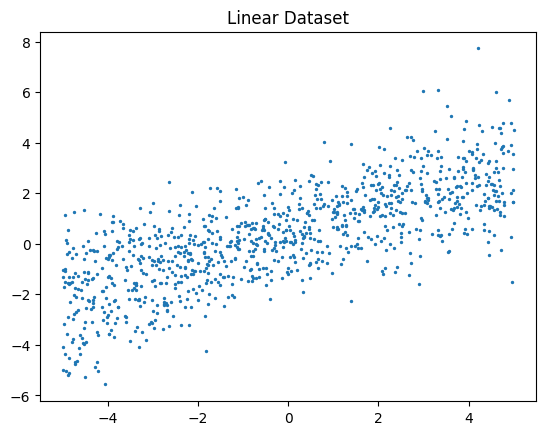

In [288]:
import matplotlib.pyplot as plt

x, y = generate_polynomial_dataset(1, 1000)
plt.scatter(x, y, s=2)
plt.title("Linear Dataset")
plt.show()

### Quadratic Dataset

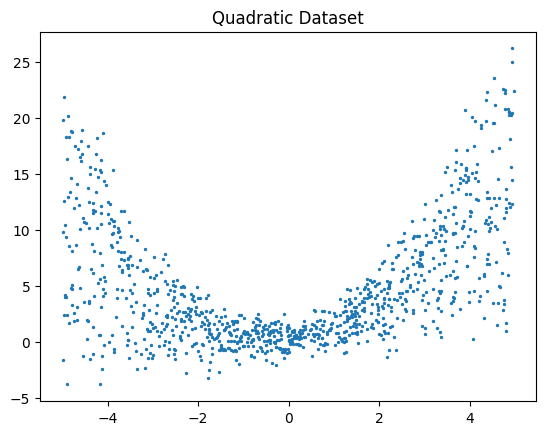

In [289]:

x, y = generate_polynomial_dataset(2, 1000)
plt.scatter(x, y, s=2)
plt.title("Quadratic Dataset")
plt.show()

### Cubic

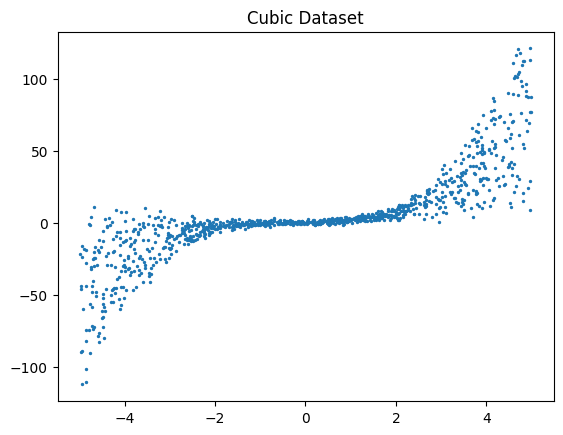

In [290]:
x, y = generate_polynomial_dataset(3, 1000)
plt.scatter(x, y, s=2)
plt.title("Cubic Dataset")
plt.show()

For ease of use and training, I have imported scikit's `train_test_split` function in order to generate training and test sets.

In [291]:
from sklearn.model_selection import train_test_split

def get_split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # If the dataset is 1D, reshape it to 2D for sklearn
    # This is necessary for sklearn to work properly
    
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
    return x_train, x_test, y_train, y_test

In order to effectively perform regression on polynomials, it is important to perform feature scaling, as such I have defined a function in order to return a feature-scaled dataset.

In [292]:
from sklearn.preprocessing import StandardScaler

def get_split_poly(x, degree):
    x_poly = x
    for i in range(1,degree):
        x_poly = np.column_stack((x_poly, x ** (i + 1)))
    return x_poly

I have also defined a simple graphing function to visualise regression results. It takes a regression model's co-efficients and intercept then generates the function of the form:

$$ y = b + a_1x + a_2x^2 + ... + a_nk^n $$

For any estimated polynomial regression. I have provided some additional functions to make the visualisation clearer and more streamlined in a notebook cell format

In [293]:
def plot_ridge_regression(alphas, x_test, y_test, results, title, ax, ylim=(-100, 100), ):
    x = np.linspace(-5, 5, 1000)

    #ylim
    ax.set_xlim(-5, 5)
    ax.set_ylim(ylim)
    # generate len(alphas) colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
    colors = colors[::-1]  # Reverse the order of colors
    ax.scatter(x_test, y_test, color="blue", alpha=0.5, label="Test Data")
    for idx, result in enumerate(results): 
        y = sum(result[i] * (x ** i) for i in range(len(result)))
        ax.plot(x, y, label=f"{alphas[idx]}α", color=colors[idx], lw=5, alpha=0.9)

        # Scatter plot of the test data
        ax.set_title(f"{title}")
        ax.legend()
    plt.tight_layout()

In [294]:
def get_ylim(y_train):
    # Get the min and max values of x_train and y_train
    y_min, y_max = np.min(y_train), np.max(y_train)

    ylim = (y_min , y_max )  
    return ylim

In [295]:
def plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6) 

    plot_ridge_regression(test_alphas, x_test, y_test, sgd_results,f"SGD @ {sample_size} samples",ax1,get_ylim(y_train))
    plot_ridge_regression(test_alphas, x_test, y_test, cls_results,f"CLS @ {sample_size} samples",ax2,get_ylim(y_train))

## Stochastic Gradient Descent Regression

In [296]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

### Model selection

#### SGD
Creating a stochastic gradient descent model requires the selection of hyperparamters tuned for the job. I have selected the following hyperparameters.

1. The penalty $l2$ as it is the scikit's equivalent of ridge regression.
2. I have selected a max_iteration of about 5000, as this will allow the model to train with a majority of the dataset before either converging or stopping.
3. I have selected the 'adaptive' parameter for learning rate of the SGDRegressor, as it is a heuritistic that adapts the learning rate depending on the model performance.

#### Closed Form Solution

Only hyperparameter is alpha, which will be defined in each test.


In [297]:
# Models for testing
sgd = SGDRegressor(max_iter=5000, penalty='l2',random_state=42,learning_rate='adaptive')
cls = ClosedFormRegressor(0)

In [298]:
import time

def get_fit_function(model, x_train, y_train):
    model.fit(x_train, y_train)
    
    # Function co-efficents + intercept for plotting of the form y = w0 + w1*x + w2*x^2 + ... + wn*x^n|
    return [model.intercept_] + list(model.coef_)

## Regression Experimentation

In order to investigate the closed form solution, we will be comparing a non closed form solution via a stochastic gradient descent regression model, with ridge regression elasticity.

### Hypothesis

*As the regularisation increases, the closed form solution will be more susceptible to regularisation than the stochastic gradient descent model.*

We will be using alphas of: 0, 0.1, 100, 1000, 10000

In [299]:
test_alphas = [0, 0.1, 100,1000,10000]

Let's take a look at the results.

### Linear Dataset regression

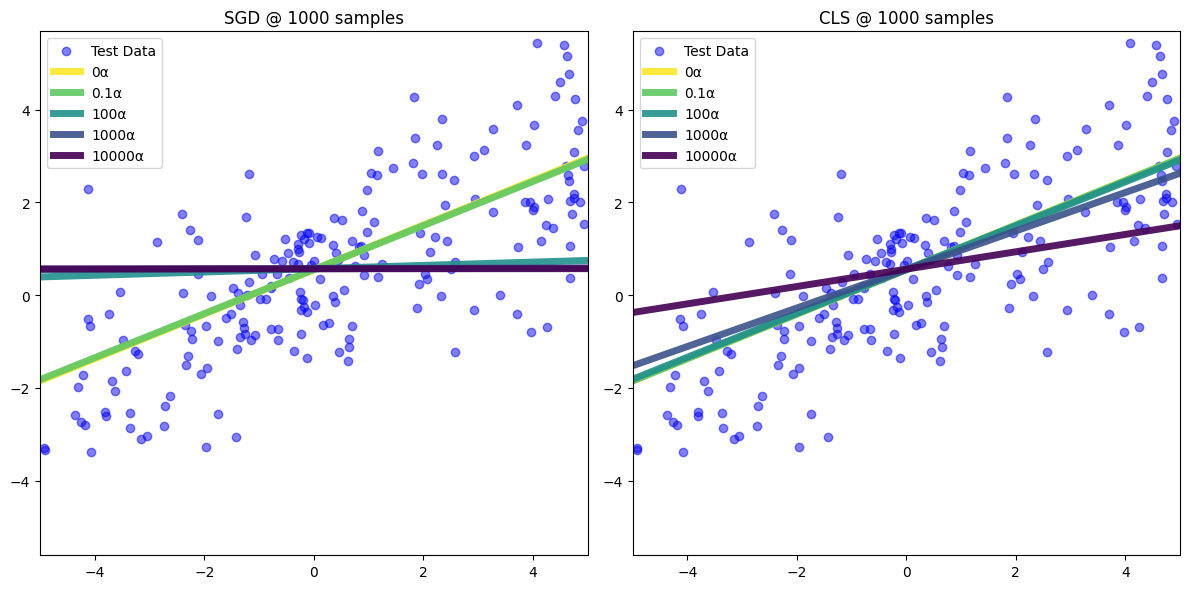

In [300]:
# Linear Datset Testing
xlin, ylin = generate_polynomial_dataset(1, 1000)
x_train, x_test, y_train, y_test = get_split(xlin, ylin)


sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha

        # fit the model and return its function
        sgd_results.append(get_fit_function(sgd, x_train, y_train)) 
        cls_results.append(get_fit_function(cls, x_train, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, 1000)


### Quadratic Dataset Regression

In [301]:
# Quadratic dataset testing
xquad, yquad = generate_polynomial_dataset(2,1000)
x_train, x_test, y_train, y_test = get_split(xquad, yquad)
x_train_poly = get_split_poly(x_train, 2)
x_test_poly = get_split_poly(x_test, 2)


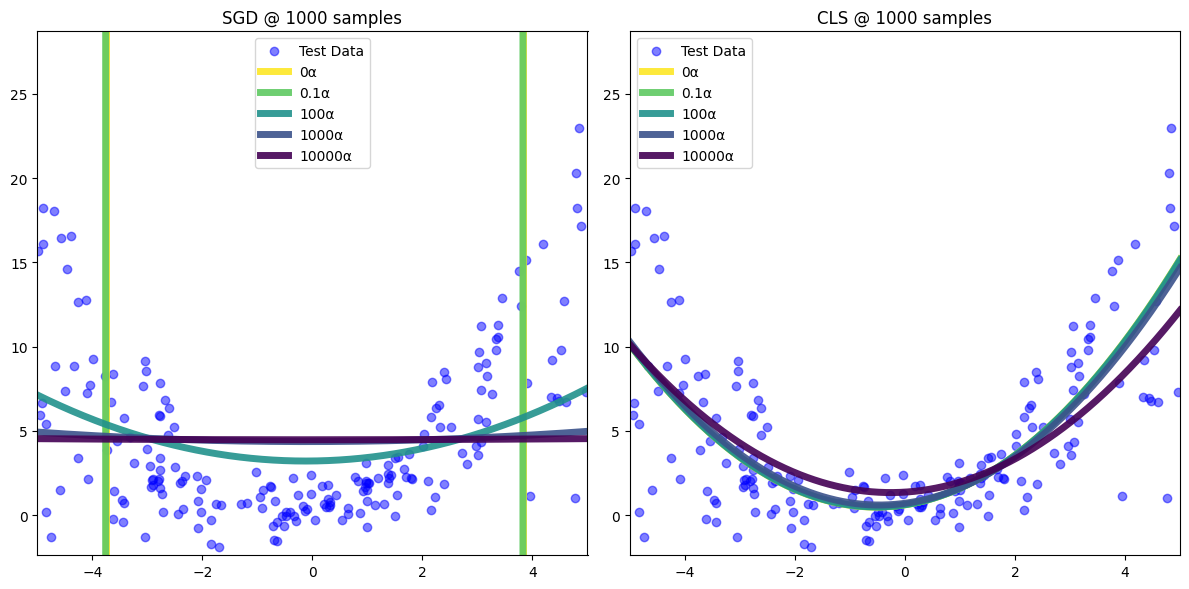

In [302]:
sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha

        # fit the model and return its function
        sgd_results.append(get_fit_function(sgd, x_train_poly, y_train)) 
        cls_results.append(get_fit_function(cls, x_train_poly, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, 1000)

### Cubic Dataset Regression


In [303]:
from sklearn.preprocessing import PolynomialFeatures

# Cubic dataset testing
x_cubic, y_cubic = generate_polynomial_dataset(3,1000)
x_train, x_test, y_train, y_test = get_split(x_cubic,y_cubic)

x_train_poly = get_split_poly(x_train, 3)
x_test_poly = get_split_poly(x_test, 3)

x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

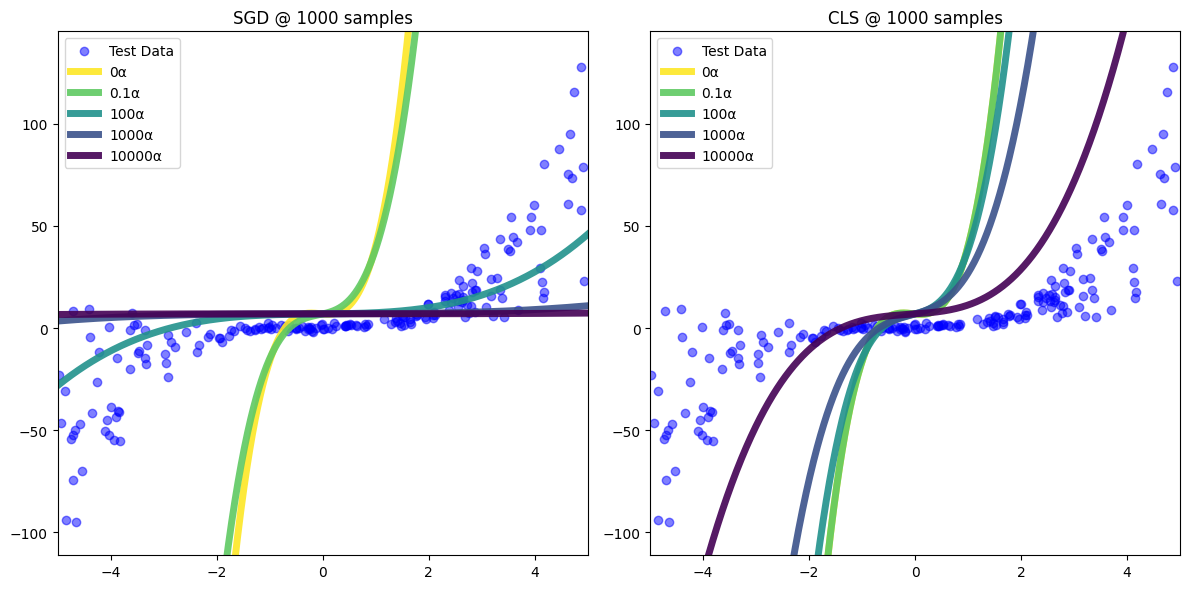

In [304]:
sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha

        # fit the model and return its function
        sgd_results.append(get_fit_function(sgd, x_train_poly, y_train)) 
        cls_results.append(get_fit_function(cls, x_train_poly, y_train))
plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, 1000)

## First Results

As we can see in the first results, for a sample size of 1000 and polynomial degree of less than or equal to 3, doesn't  support the hypothesis that regularisation has a much greater effect on the Closed Form solution. However, the exploration of hyperparameters is rather small, so we let's examine large sample sizes, and larger polynomial degrees. Another variable to consider is the *length* of training time, so we will time the training time for sample size increases and higher polynomials.

In [305]:
def time_to_fit(model,x_train, y_train):
    start = time.perf_counter_ns()
    model.fit(x_train, y_train)
    end = time.perf_counter_ns()
    return end - start


## Higher Degree Polynomials and Large n_samples

For further testing, we will examine:

1. A cubic dataset, with samples: [1000, 2000, 5000, 10000]
2. Datasets of polynomial degree:  [5,8,11]
3. A higher polynomial degree of 11 alongside a higher sample size of 5000

Models will be as per prior tests.

In [306]:
sgd = SGDRegressor(max_iter=1000, random_state=42)
cls = ClosedFormRegressor(0)

### Cubic Datasets of varying sample size


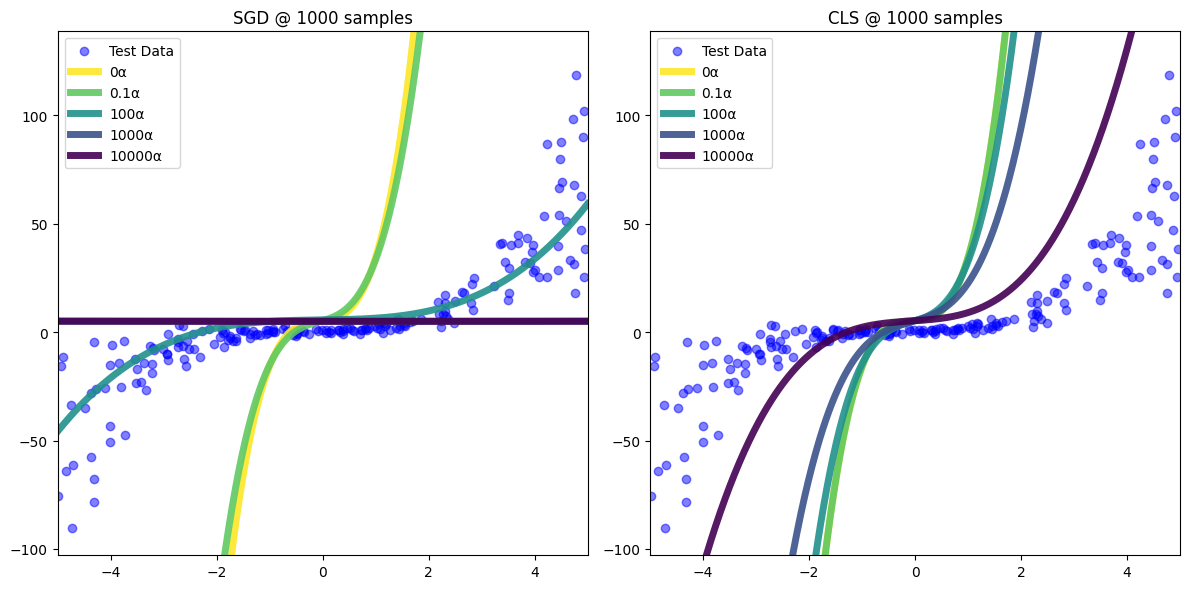

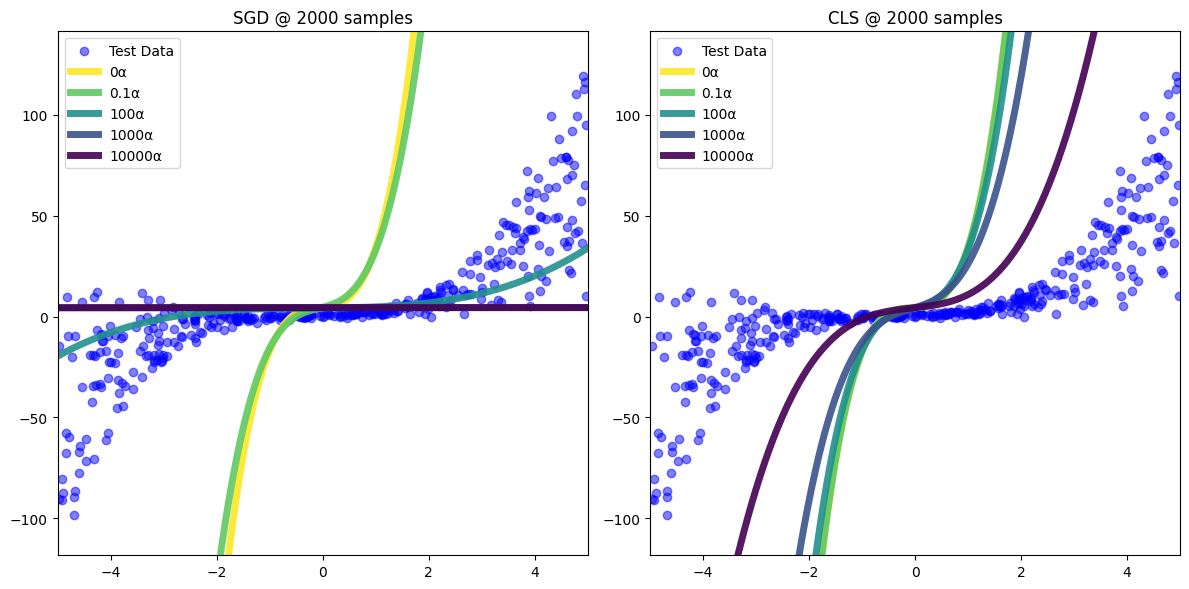

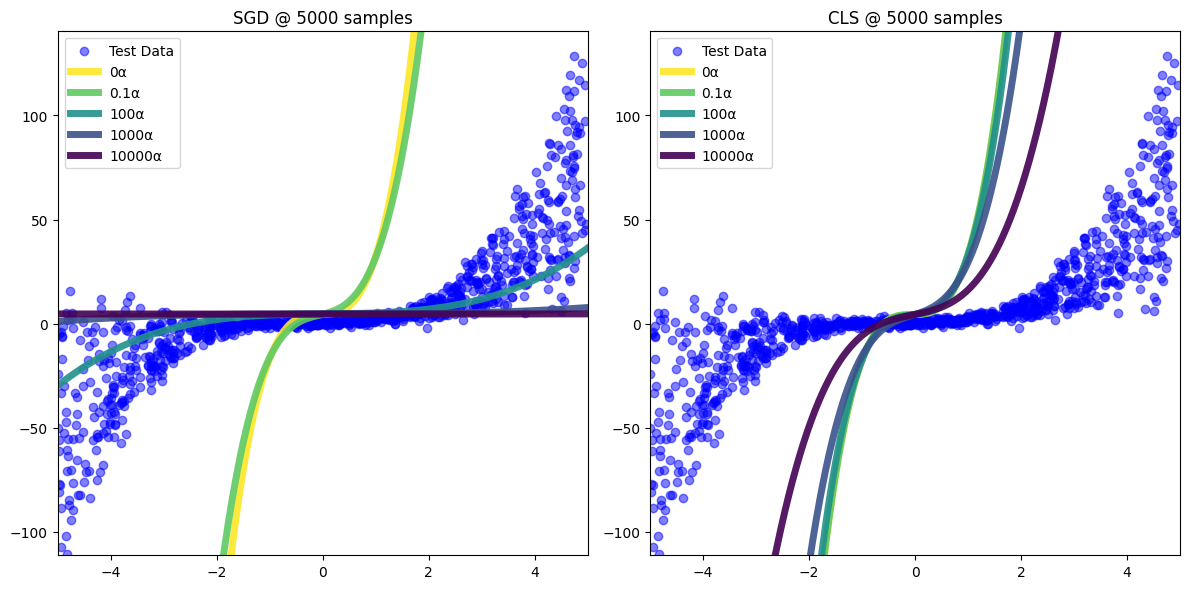

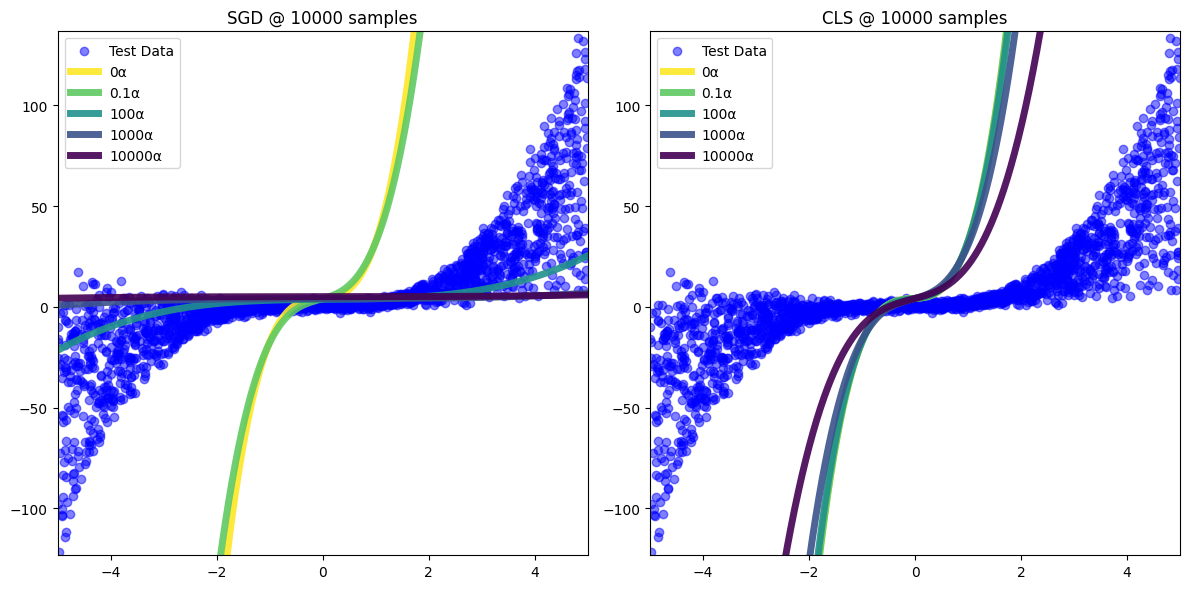

In [307]:

# Higher degree polynomial dataset testing
sample_sizes = [1000, 2000, 5000, 10000]
degree = 3

sgd_times = []
cls_times = []

for sample_size in sample_sizes:
    cubic_x, cubic_y = generate_polynomial_dataset(degree,sample_size)
    x_train, x_test, y_train, y_test = get_split(cubic_x,cubic_y)
    x_train_poly = get_split_poly(x_train, degree)
    x_test_poly = get_split_poly(x_test, degree)

    
    x_train_poly = StandardScaler().fit_transform(x_train_poly)
    x_test_poly = StandardScaler().fit_transform(x_test_poly)

    x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape

    sgd_results = []
    cls_results = []
    for alpha in test_alphas:
            sgd.set_params(alpha=alpha)
            cls.alpha = alpha
            
            sgd_results.append(get_fit_function(sgd,x_train_poly, y_train))
            cls_results.append(get_fit_function(cls,x_train_poly, y_train))

    sgd_times.append(time_to_fit(sgd,x_train_poly, y_train))
    cls_times.append(time_to_fit(cls,x_train_poly, y_train))
            
    plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size)

Lets take a look at the time to fit for each sample size.


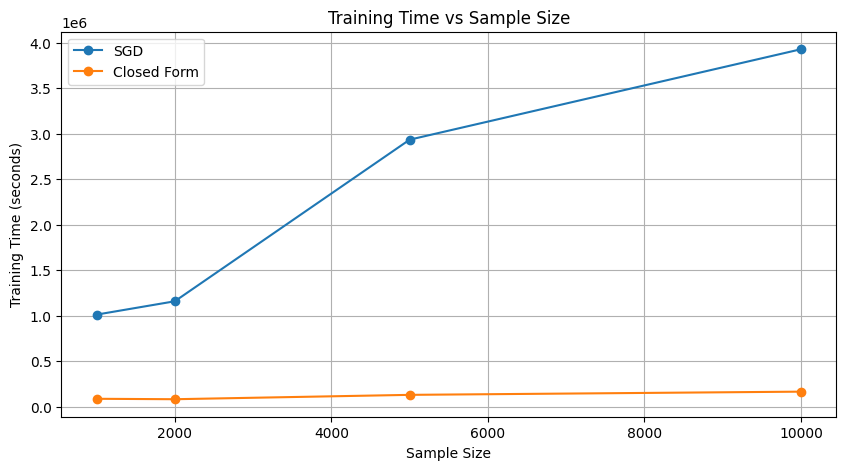

In [308]:
# Plot times
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, sgd_times, label="SGD", marker='o')
plt.plot(sample_sizes, cls_times, label="Closed Form", marker='o')
plt.title("Training Time vs Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.grid()
plt.show()

### 5th Degree Polynomial Regression

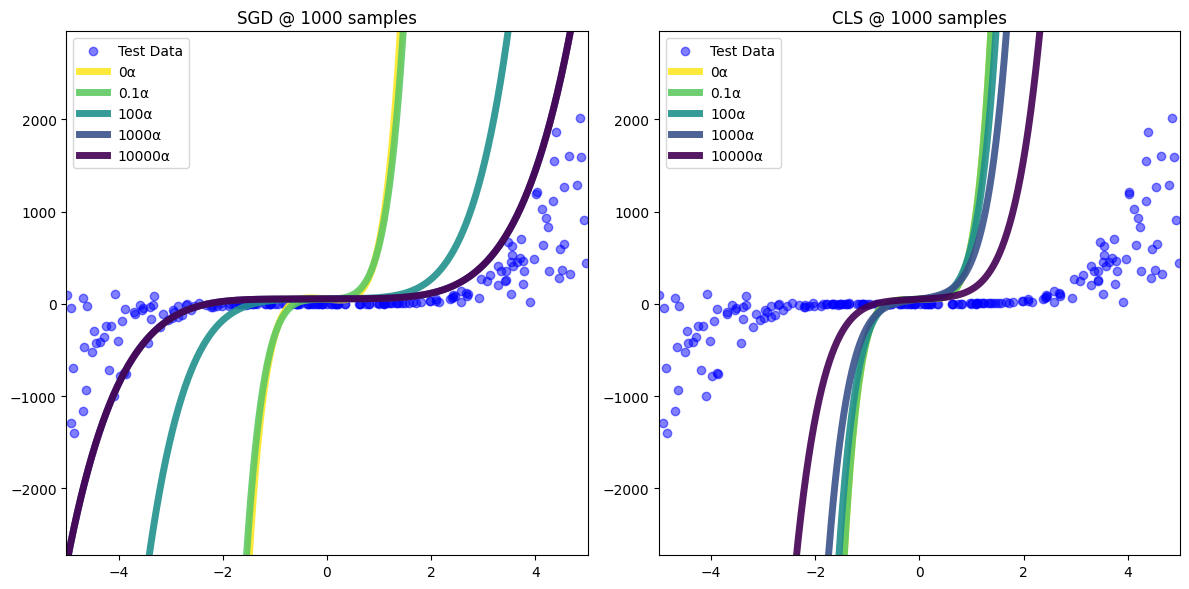

In [309]:
# Higher degree polynomial dataset testing
sample_size = 1000
degree = 5
x, y = generate_polynomial_dataset(degree,sample_size)
x_train, x_test, y_train, y_test = get_split(x,y)
x_train_poly = get_split_poly(x_train, degree)
x_test_poly = get_split_poly(x_test, degree)


x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape

sgd_results = []
cls_results = []

sgd_times = []
cls_times = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha

        sgd_times.append(time_to_fit(sgd, x_train_poly,y_train))
        cls_times.append(time_to_fit(cls, x_train_poly,y_train))
        
        sgd_results.append(get_fit_function(sgd,x_train_poly, y_train))
        cls_results.append(get_fit_function(cls,x_train_poly, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size)

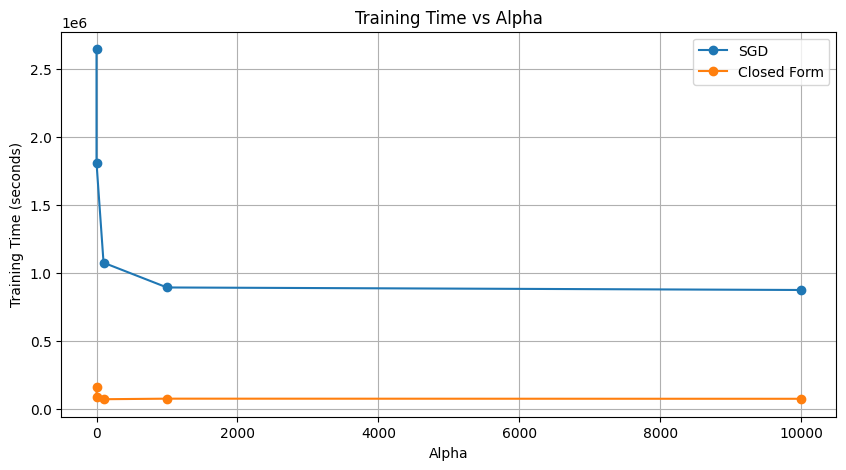

In [310]:
plt.figure(figsize=(10, 5))
plt.plot(test_alphas, sgd_times, label="SGD", marker='o')
plt.plot(test_alphas, cls_times, label="Closed Form", marker='o')
plt.title("Training Time vs Alpha")
plt.xlabel("Alpha")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.grid()
plt.show()

### 8th Degree Polynomial Regression

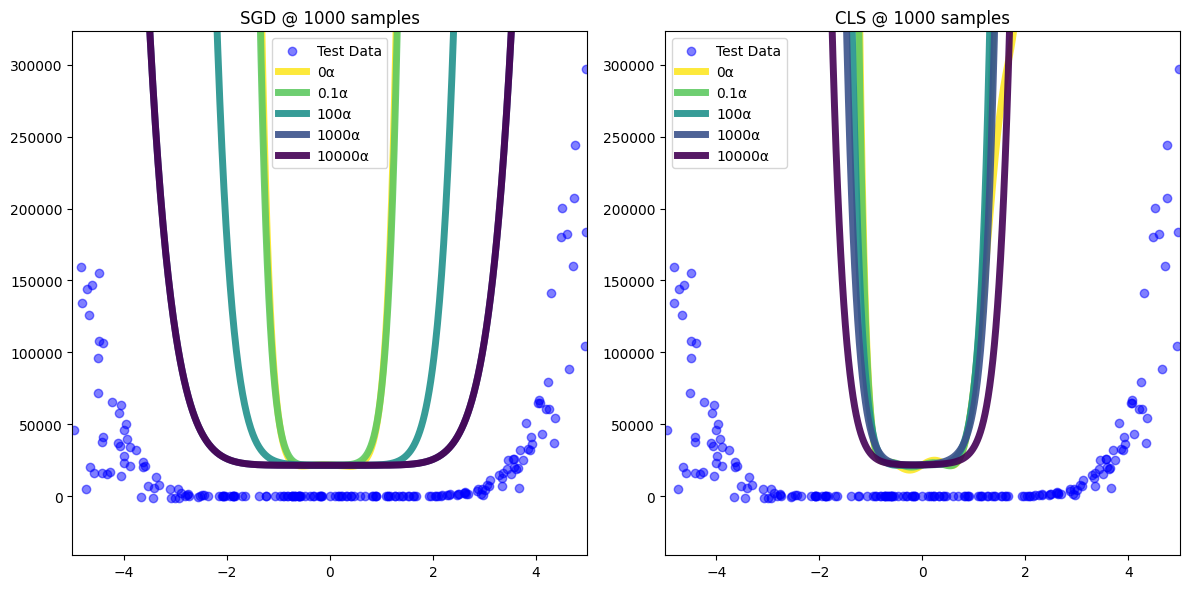

In [311]:
# Higher degree polynomial dataset testing

# Higher degree polynomial dataset testing
sample_size = 1000
degree = 8
x, y = generate_polynomial_dataset(degree,sample_size)
x_train, x_test, y_train, y_test = get_split(x,y)
x_train_poly = get_split_poly(x_train, degree)
x_test_poly = get_split_poly(x_test, degree)


x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape

sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha
        sgd_results.append(get_fit_function(sgd,x_train_poly, y_train))
        cls_results.append(get_fit_function(cls,x_train_poly, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size)

### 11th Degree Polynomial Regression

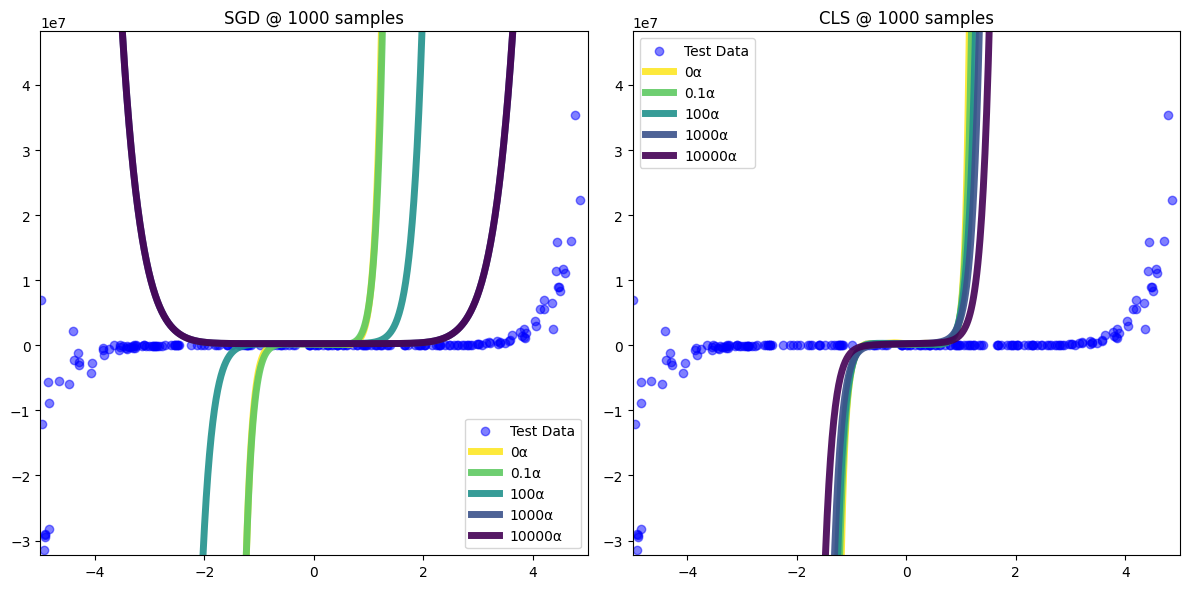

In [312]:
# Higher degree polynomial dataset testing
sample_size = 1000
degree = 11
x, y = generate_polynomial_dataset(degree,sample_size)
x_train, x_test, y_train, y_test = get_split(x,y)
x_train_poly = get_split_poly(x_train, degree)
x_test_poly = get_split_poly(x_test, degree)


x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape

sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha
        sgd_results.append(get_fit_function(sgd,x_train_poly, y_train))
        cls_results.append(get_fit_function(cls,x_train_poly, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size)

### 11th Degree and 5000 samples

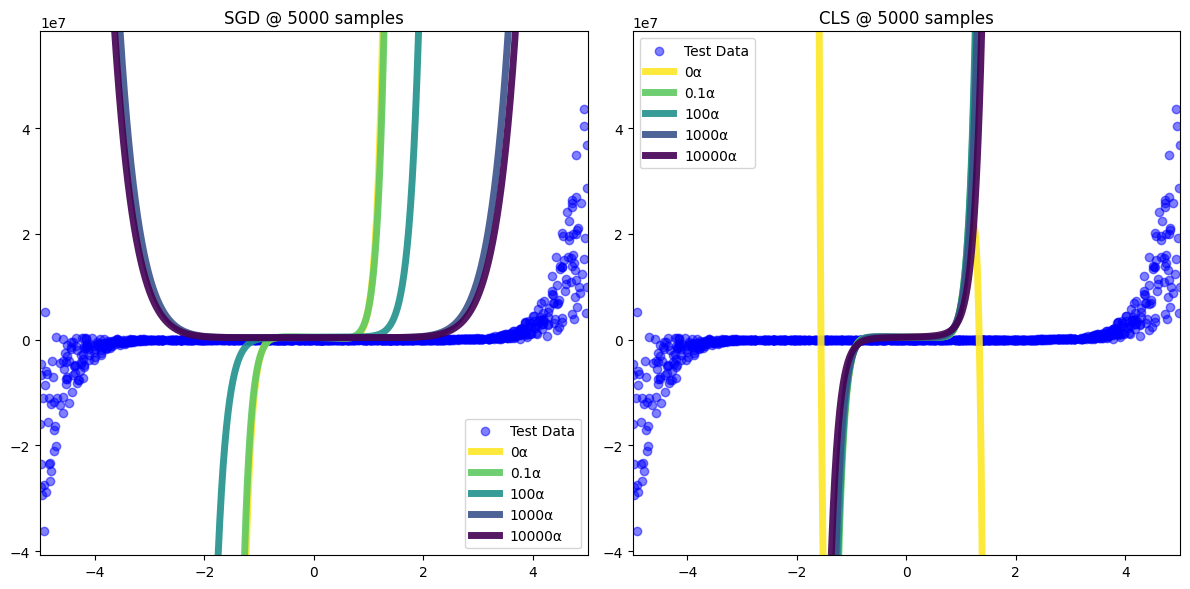

In [313]:
# Higher degree polynomial dataset testing
sample_size = 5000
degree = 11
x, y = generate_polynomial_dataset(degree,sample_size)
x_train, x_test, y_train, y_test = get_split(x,y)
x_train_poly = get_split_poly(x_train, degree)
x_test_poly = get_split_poly(x_test, degree)

x_train_poly = StandardScaler().fit_transform(x_train_poly)
x_test_poly = StandardScaler().fit_transform(x_test_poly)

x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape

sgd_results = []
cls_results = []
for alpha in test_alphas:
        sgd.set_params(alpha=alpha)
        cls.alpha = alpha
        sgd_results.append(get_fit_function(sgd,x_train_poly, y_train))
        cls_results.append(get_fit_function(cls,x_train_poly, y_train))

plot_sidebyside(sgd_results, cls_results, test_alphas, x_test, y_test, y_train, sample_size)

## Discussion of Results

1. *How does the closed form solution compare the SGDRegressor?*

With the investigation of higher polynomials and sample sizes, the effect of regularisation seems to be consistent as these variables increase.

As we can see in the results from the sample_size variations, the increased sample size doesn't have a large effect on the performance of both models. This can be attributed to the fact that the models are largely *overfitting*, and the increased sample size is not significant in the reduction of the overfitting. Increasing sample size is usually correlated with the reduction of *underfitting*, thus will not affect a model's ability to reduce overfitting.

From analysing the results in the polynomial degree variations, we can see that as the polynomial degree increases, the regularisation required in order to avoid overfitting increases significantly. The regularisation still has a greater effect on the stochastic gradient descent model compared to the closed form solution, but has shown to be useful in higher degree polynomials.

Both models struggled considerably as the degree increased, but the SGD models susceptibility to regularisation proved to be advantageous as it could more effecitvely approximate the functions as the polynomial complexity increased. The closed form solution heavily overfitted the data, and struggled to reduce its overfitting with regularisation.

2. *Which implementation will be faster to fit?*

The regularisation susceptability can be a positive or a negative, depending on the use case. However, the complexity and time to compute is an issue relevant to all datasets and domain spaces. As we can see in the time figures, the closed form solution is signficiantly faster than the stochastic gradient descent model. When the alpha is high, the SGD model has a larger training time, which decreases as the regularisation increases. The closed form solution, by nature of being closed form, has a near constant compute time, with it fitting to the data much faster.

### Conclusion

We can conclude that the hypothesis is false:

*As the regularisation increases, the closed form solution will be more susceptible to regularisation than the stochastic gradient descent model.*

The increased effect regularisation has the stochastic gradient descent model can be seen as a postive, as we can adjust it to better fit the data. It has a wider range of regularisation parameters which can produce better results. However, the training time of the SGD model is much slower, so the closed form solution may be feasible for instances in which a fast solution is required, without much requirement for incredibly high accuracy.




# Part 2 Support Vector Classifiers

The implementation of machine learning models in medical imaging has been a revolutionary tool for the classification and identification of potential medical conditions. Within this part of the notebook, I will be investigating the implemenetation of a Support Vector Classifier, in order to classify malignant or benign breast features. 

## What is a support vector classifier?

A support vector machine can be thought as fitting the widest possible *street* between classification classes. Its formal definition is **large margin classification**. The edges of the street are known as *support vectors*, and the centre line is the *decision* boundary. Ensuring all possible instances are on either side of the *street* is known as **hard margin classification**. This approach is only feasible if the data is linearly separable, and falls apart with outliers. **Soft margin classification** provides leniency on street edges, not requiring all data to be on either side. By tuning a hyperparameter $C$, we can influence the rigidiness of the street and adjust it to fit our data effectively.

In this section of the notebook, it will be investigating soft margin classification on the *Diagnostic Wisconsin Breast Cancer Database*, attempting to determine whether input features can accurately predict a malginant or benign output.

## Dataset

For this task, we will be using the *Diagnostic Wisconsin Breast Cancer Database*, sourced from:

https://doi.org/10.24432/C5DW2B

The dataset contains 32 features, in the following format.

1. Patient Identification Number
2. Diagnosis, where x $\in [M, B]$, with M being Malignant and B being Benign

As the identification number has no influence on the classification, we can remove it. For the next 30 Features, it is the *mean*, *standard error* and *worst* ( or largest ) of the following features:

- Mean values of cell nuclei features (radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension)
- Standard error of these features
- Worst (largest) values of these features
- Diagnosis labels: Malignant (M) or Benign (B)
- The dataset contains 569 samples, with 357 benign and 212 malignant cases.
- The features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.
- Each feature is a real-valued number.
- The dataset is widely used for binary classification tasks in machine learning.
- The target variable is the diagnosis column, which we will encode for model training.


Thus, columns **3-11** are mean, columns **12-21** are standard error, and columns **22-31**. 

We can implement this by reading in the database with pandas. 

In [314]:
import pandas as pd

data = pd.read_csv('wdbc.data', header=None)

# Column 0 is the ID, which is not need for classification
# Column 1 is the diagnosis, needed as the label of the classification
# 2 - 11 are mean values
# 12 - 21 are standard error
# 22 - 31 are worst

# Dropping the ID column
data.drop(columns=[0], inplace=True)

# Naming the columns
data.columns = ['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean',
               'smoothness_mean','compactness_mean','concavity_mean','concave_points_mean',
               'symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
               'area_se','smoothness_se','compactness_se','concavity_se','concave_points_se',
               'symmetry_se','fractal_dimension_se','radius_worst','texture_worst','perimeter_worst',
               'area_worst','smoothness_worst','compactness_worst','concavity_worst',
               'concave_points_worst','symmetry_worst','fractal_dimension_worst']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave_points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### Dataset Cleaning

In order to process and classify the data, we must encode the classification labels, *M* and *B* into a integer for the model. Thus, we will use sklearn's *OrdinalEncoder* to do this for us.

In [315]:
from sklearn.preprocessing import OrdinalEncoder

labels = data.iloc[:, 0].values

labels = pd.DataFrame(labels, columns=["diagnosis"])

print("-------- Labels head (5) --------")

print(labels.head(5))


enc = OrdinalEncoder(categories=[["B", "M"]])
labels_encoded = enc.fit_transform(labels)
labels_encoded = np.reshape(labels_encoded, -1)


all_data = data.iloc[:, 1:31].values

print("-------- Unique encoded values --------")
print(np.unique(labels_encoded))

print("-------- Encoded Labels head (5) --------")
print(labels_encoded[:5])

print("-------- Encoded Labels counts --------")
print(np.unique(labels_encoded, return_counts=True))


-------- Labels head (5) --------
  diagnosis
0         M
1         M
2         M
3         M
4         M
-------- Unique encoded values --------
[0. 1.]
-------- Encoded Labels head (5) --------
[1. 1. 1. 1. 1.]
-------- Encoded Labels counts --------
(array([0., 1.]), array([357, 212]))


The $M$ label got encoded into 1, and the $B$ label will thus have been encoded into 0. However, as we can see in the count section, we have an imbalance in our classes. There is 212 instances of M, and there is 357 counts of B. This requires the stratification of the data in order for our classification model to work effectively.

## Grid Search and the SVC model

We can implement the stratification of data with scikits train_test_split function, ensuring that the split we receive provides an equal proportion of labels in the training and test set.

In [316]:
x_train, x_test, y_train, y_test = train_test_split(all_data, labels_encoded, stratify=labels_encoded, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

### Scoring the classifier.

For the scoring of the model, we can examine accuracy, precision and recall. For a model that is estimating whether someone has a malignant instance, it is of utmost importance that all subjects that have a malignant result are predicted correctly. False negatives are much more costly than false positive, we can use recall for our scoring metric.

As recall is:

$ Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}$

Our aim is to maintain the highest possible recall for the M label ( or 0 ), while maintaing a high degree of precision so as to avoid diagnosing every instance in the dataset.

#### Options

It is possible to use a precision scoring metric, if the aim of the model is not necessarily to be a single shot classification method. If the model is part of a larger diagnosis ecosystem, for example being used alongside physical evaluations or domain specific knowledge, a very high precision model could be a supplementary tool that doctors and experts could use to help them diagnose patients, rather than the definitive model used for malignant predictions.

### Performing the GridSearch

In order to evaluate the SVC model, the GridSearchCV alongside scikit's SVC model to identify optimal hyper-parameters for the classification. I have opted to use a Gaussin RBF kernel, so the hyper-parameters investigated will be $C$ and the *gamma* of the the kernel. By having 4 different options for each hyper-parameters, there will be $8$ / $4^2$ models examined.

In [317]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

rbf_params = {
    'C': [0.1, 1, 10, 50],
    'gamma': [0,0.001,0.05,0.3],
}


As there is an imbalance of classes,Stratified 5-fold cross validation will be implemented. By specifying a Stratified K-Fold approach, it will ensure that the proportion of respective classes will remain consistent between folds.

In [318]:
from sklearn.metrics import classification_report, confusion_matrix


print(f"Scoring: Recall")
svc_gs = GridSearchCV(SVC(random_state=42,kernel='rbf'), rbf_params, cv=StratifiedKFold(5), scoring='recall')
svc_gs.fit(x_train, y_train)

best_model = svc_gs.best_estimator_

print(f"Best params: {svc_gs.best_params_}")
print(f"Best Score: {svc_gs.best_score_}")

y_pred = best_model.predict(x_train)
print("Confusion Matrix")
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))



Scoring: Recall
Best params: {'C': 1, 'gamma': 0.001}
Best Score: 0.9431451612903226
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       267
         1.0       0.99      0.97      0.98       159

    accuracy                           0.98       426
   macro avg       0.98      0.98      0.98       426
weighted avg       0.98      0.98      0.98       426

[[265   2]
 [  5 154]]


Thus, the best hyperparemeters from the GridSearch after fitting $8$ or  $ 4^2 $  models with the recall scoring metric, is:

- $C$: 0.1
- $ \gamma$ :0.001

### Testing the Model

In [319]:
# list of param combinations, with precision, recall, accuracy

y_pred = svc_gs.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94        90
         1.0       0.94      0.83      0.88        53

    accuracy                           0.92       143
   macro avg       0.92      0.90      0.91       143
weighted avg       0.92      0.92      0.91       143

[[87  3]
 [ 9 44]]


As the above figures display, the model's recall is not as effective compared to the training set, but it is still relatively effective at 83% recall.

## Discussion Of Results

1. Would you be confident in implementing this for real-world breast cancer screening? Explain your
reasoning.

At a recall score of 83% with around 94% precision, this could be an effective tool for the classification of malignant instances. As mentioned in the scoring metric discussion, having a high recall with a high precision means that it will provide insight into the possiblity of a malignant instance. As the recall is not 100% however, it cannot be used as a definitive diagnosis tool, especially when it comes to breast cancer. 83% means that 1 in 5 people that have a malginant instance will not be diagnosed as such, thus the model must be used as a supplementary tool for the assistance of diagnosis

2. What about precision/recall curves? Would they be useful for this task? Could you implement them
for your model? Explain your reasoning.

Precision recall curves would be an effective metric that can be used to select better hyper-parameters. The ideal model would have high recall and precision,  but that is not always possible. By using a precision recall curve, it would be possible to adjust the values of the recall and precision to a balance which is suitable for prediction. As mentioned in the discussion surrounding the scoring metric, ensuring a high recall is paramount, but would be useless if the precision is very low. It is possible to have a high recall model by just classifying all instances as malignant, at which point the model is useless. 

Thus, the tradeoff between precision and recall will likely have to be selected by domain experts. For example, a doctor may prefer a model with 80% recall and 80% precision over a model with 95% recall and say 45% precision.